In [ ]:
# -------------------------
# Data Handling
# -------------------------
import pandas as pd
import numpy as np

# -------------------------
# Visualization
# -------------------------
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# -------------------------
# Text Analysis / NLP
# -------------------------
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
nltk.download('punkt')
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10,6)


[nltk_data] Downloading package stopwords to C:\Users\HP
[nltk_data]     EliteBook\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\HP
[nltk_data]     EliteBook\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
# Load cleaned review data
df = pd.read_csv("../data/processed/final_cleaned_reviewed.csv")

print(df.head())
print(df.info())


                              review_id  \
0  809c46d2-730e-446a-9061-2a45e978ad9d   
1  63f63b8b-016a-4262-a27e-f0de9ebf985a   
2  f28a3a3c-eb94-4aab-88d2-89bcecebcc7b   
3  4ed89e8c-16dc-4763-94ca-04d05cf799a5   
4  f5bfd792-bc81-4d06-99c9-06c7743d3e09   

                                         review_text  rating review_date  \
0                                           good jop       5  2025-11-27   
1                                                 ok       5  2025-11-27   
2                   bad exprience...it is so crushed       1  2025-11-27   
3  not user friendly at all it requires a huge co...       1  2025-11-26   
4                                                          1  2025-11-26   

   review_year  review_month bank_code_x       bank_name       user_name  \
0         2025            11   Abyssinia  Abyssinia Bank  Yohanis Fikadu   
1         2025            11   Abyssinia  Abyssinia Bank       Butu Mare   
2         2025            11   Abyssinia  Abyssinia Bank

In [14]:
# Average rating per bank
print(df.groupby('bank_name')['rating'].mean())

# Count of reviews per bank
print(df['bank_name'].value_counts())

# Count of reviews by sentiment
print(df.groupby(['bank_name', 'sentiment_label']).size())


bank_name
Abyssinia Bank                 3.345455
Commercial Bank of Ethiopia    4.117949
Dashen Bank                    3.933333
Name: rating, dtype: float64
bank_name
Commercial Bank of Ethiopia    390
Dashen Bank                    390
Abyssinia Bank                 385
Name: count, dtype: int64
bank_name                    sentiment_label
Abyssinia Bank               negative            74
                             neutral            114
                             positive           197
Commercial Bank of Ethiopia  negative            30
                             neutral            114
                             positive           246
Dashen Bank                  negative            48
                             neutral             68
                             positive           274
dtype: int64


In [ ]:
# Convert 'identified_themes' from string representation of list to actual list
import ast

def convert_theme_list(x):
    if isinstance(x, list):
        return x
    if pd.isna(x):
        return []
    try:
        return ast.literal_eval(x)  
    except:
        return []

df['identified_themes'] = df['identified_themes'].apply(convert_theme_list)


In [ ]:
from collections import Counter
import re

def extract_insights(df, bank_name, top_n=10):
    bank_df = df[df["bank_name"] == bank_name]
    
    pos_words = " ".join(bank_df[bank_df['sentiment_label'] == 'positive']['clean_text']).lower().split()
    neg_words = " ".join(bank_df[bank_df['sentiment_label'] == 'negative']['clean_text']).lower().split()
    
    pos_words = [w for w in pos_words if len(w) > 2]
    neg_words = [w for w in neg_words if len(w) > 2]

    drivers = Counter(pos_words).most_common(top_n)
    pain_points = Counter(neg_words).most_common(top_n)

    pos_themes = Counter([t for themes in bank_df[bank_df['sentiment_label']=='positive']['identified_themes'] 
                          for t in themes]).most_common(top_n)

    neg_themes = Counter([t for themes in bank_df[bank_df['sentiment_label']=='negative']['identified_themes'] 
                          for t in themes]).most_common(top_n)

    return {
        "drivers_words": drivers,
        "painpoint_words": pain_points,
        "positive_themes": pos_themes,
        "negative_themes": neg_themes
    }
banks = df['bank_name'].unique()

insights = {}
for bank in banks:
    insights[bank] = extract_insights(df, bank)

insights


{'Abyssinia Bank': {'drivers_words': [('good', 84),
   ('app', 77),
   ('not', 25),
   ('please', 24),
   ('bank', 24),
   ('use', 18),
   ('nice', 17),
   ('like', 15),
   ('boa', 15),
   ('work', 14)],
  'painpoint_words': [('app', 61),
   ('bad', 32),
   ('not', 18),
   ('time', 18),
   ('work', 17),
   ('bank', 15),
   ('ever', 13),
   ('update', 11),
   ('fix', 11),
   ('banking', 10)],
  'positive_themes': [('Other', 197)],
  'negative_themes': [('Other', 74)]},
 'Commercial Bank of Ethiopia': {'drivers_words': [('good', 100),
   ('app', 90),
   ('nice', 25),
   ('well', 23),
   ('bank', 20),
   ('update', 17),
   ('use', 16),
   ('application', 15),
   ('cbe', 15),
   ('like', 15)],
  'painpoint_words': [('app', 14),
   ('not', 11),
   ('work', 8),
   ('bad', 6),
   ('cbe', 6),
   ('bank', 6),
   ('can', 5),
   ('show', 5),
   ('transaction', 5),
   ('say', 5)],
  'positive_themes': [('Other', 246)],
  'negative_themes': [('Other', 30)]},
 'Dashen Bank': {'drivers_words': [('app

In [33]:
avg_ratings = df.groupby('bank_name')['rating'].mean().sort_values(ascending=False)
print("Average ratings per bank:\n", avg_ratings)

Average ratings per bank:
 bank_name
Commercial Bank of Ethiopia    4.117949
Dashen Bank                    3.933333
Abyssinia Bank                 3.345455
Name: rating, dtype: float64


In [34]:
sentiment_counts = df.groupby(['bank_name', 'sentiment_label']).size().unstack(fill_value=0)
sentiment_counts['total'] = sentiment_counts.sum(axis=1)
sentiment_counts['positive_ratio'] = sentiment_counts.get('positive',0)/sentiment_counts['total']
sentiment_counts['negative_ratio'] = sentiment_counts.get('negative',0)/sentiment_counts['total']

print("Sentiment distribution per bank:\n", sentiment_counts)


Sentiment distribution per bank:
 sentiment_label              negative  neutral  positive  total  \
bank_name                                                         
Abyssinia Bank                     74      114       197    385   
Commercial Bank of Ethiopia        30      114       246    390   
Dashen Bank                        48       68       274    390   

sentiment_label              positive_ratio  negative_ratio  
bank_name                                                    
Abyssinia Bank                     0.511688        0.192208  
Commercial Bank of Ethiopia        0.630769        0.076923  
Dashen Bank                        0.702564        0.123077  


In [36]:
compare_df = pd.DataFrame({
    'avg_rating': df.groupby('bank_name')['rating'].mean(),
    'positive_ratio': sentiment_counts['positive_ratio'],
    'negative_ratio': sentiment_counts['negative_ratio'],
    'top_positive_themes': [top_pos_themes[bank] for bank in banks],
    'top_negative_themes': [top_neg_themes[bank] for bank in banks]
})
compare_df

,avg_rating,positive_ratio,negative_ratio,top_positive_themes,top_negative_themes
bank_name,,,,,
Abyssinia Bank,3.345455,0.511688,0.192208,[Other],[Other]
Commercial Bank of Ethiopia,4.117949,0.630769,0.076923,[Other],[Other]
Dashen Bank,3.933333,0.702564,0.123077,[Other],[Other]


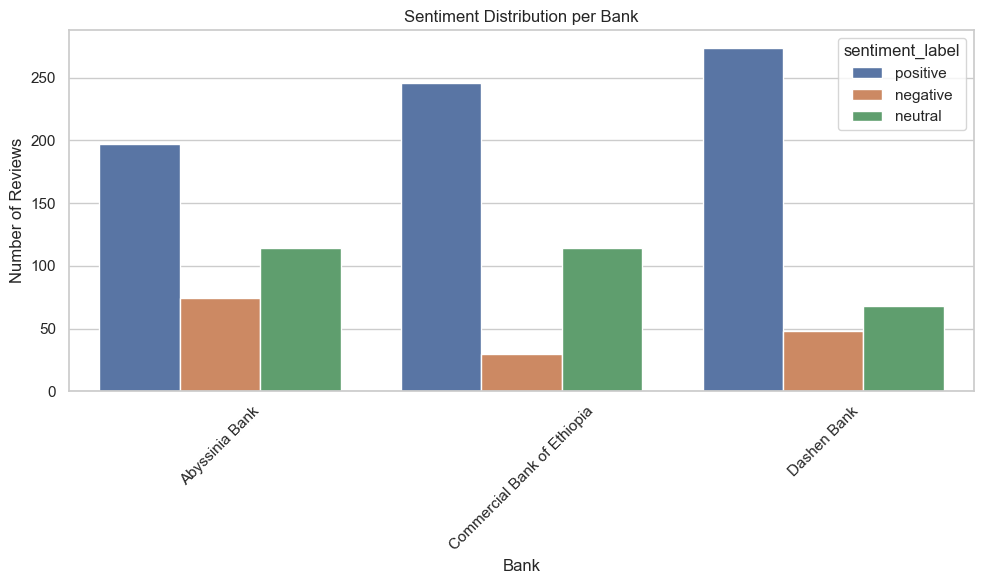

In [17]:
# Visualization: Sentiment distribution per bank
plt.figure(figsize=(10,6))
sns.countplot(data=df, x='bank_name', hue='sentiment_label')
plt.title("Sentiment Distribution per Bank")
plt.xlabel("Bank")
plt.ylabel("Number of Reviews")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


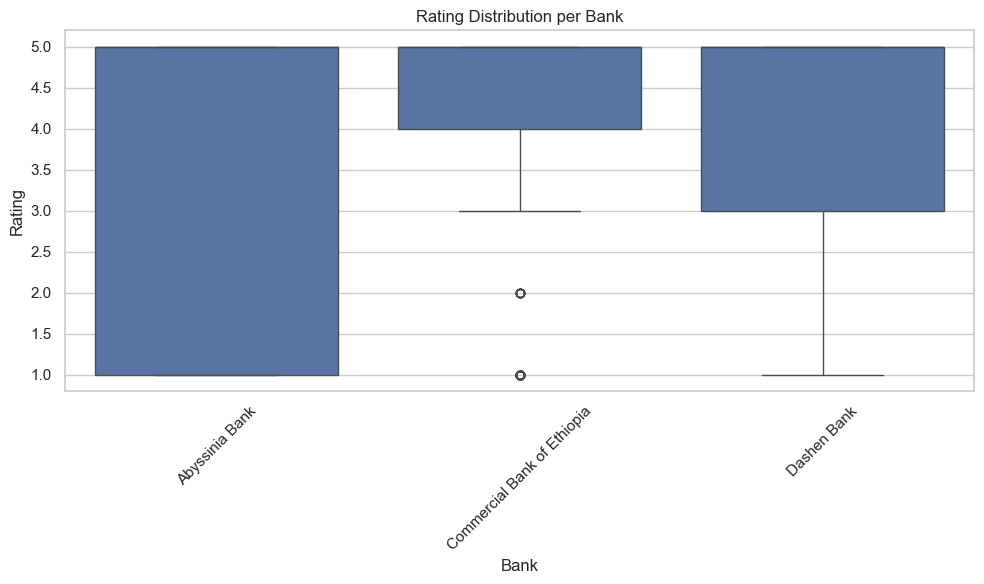

In [18]:
plt.figure(figsize=(10,6))
sns.boxplot(data=df, x='bank_name', y='rating')
plt.title("Rating Distribution per Bank")
plt.xlabel("Bank")
plt.ylabel("Rating")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


C:\Users\HP EliteBook\AppData\Local\Temp\ipykernel_44396\1509756014.py:2: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(data=df, x='bank_name', y='rating', errorbar='ci', join=False)


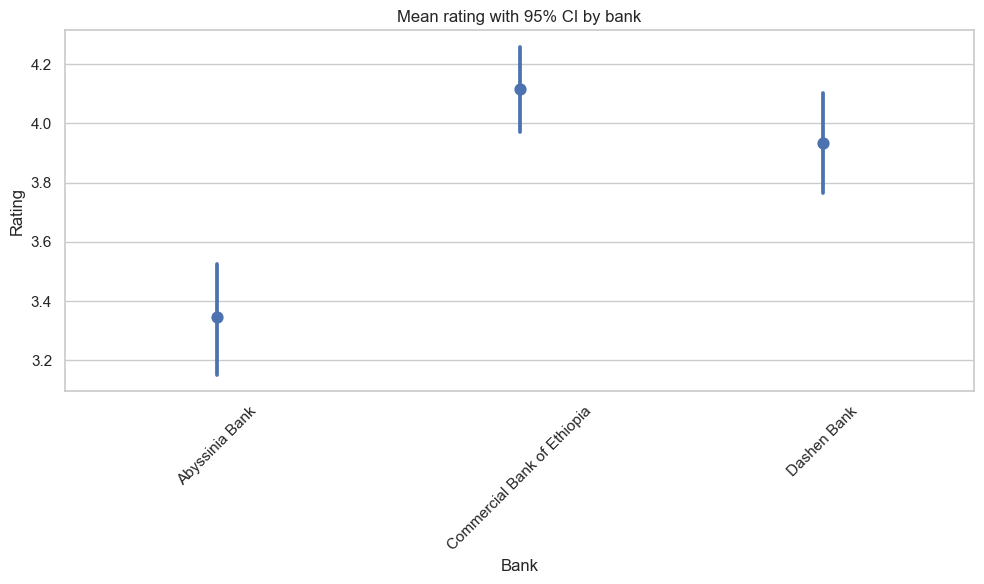

In [37]:
plt.figure(figsize=(10,6))
sns.pointplot(data=df, x='bank_name', y='rating', errorbar='ci', join=False)
plt.title('Mean rating with 95% CI by bank')
plt.xlabel('Bank'); plt.ylabel('Rating')
plt.xticks(rotation=45); plt.tight_layout(); plt.show()

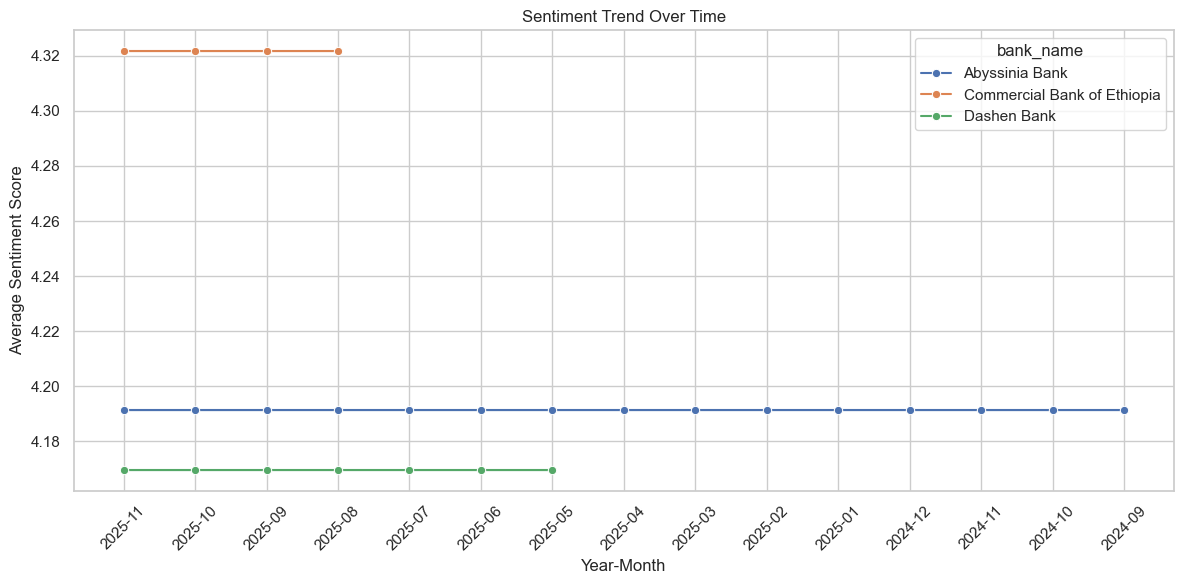

In [ ]:
# Visualization: Sentiment trend over time
df['review_date'] = pd.to_datetime(df['review_date'])
df['year_month'] = df['review_date'].dt.to_period('M').astype(str)

plt.figure(figsize=(12,6))
sns.lineplot(
    data=df,
    x='year_month',
    y='sentiment_score',
    hue='bank_name',
    marker='o'
)
plt.title("Sentiment Trend Over Time")
plt.xlabel("Year-Month")
plt.ylabel("Average Sentiment Score")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

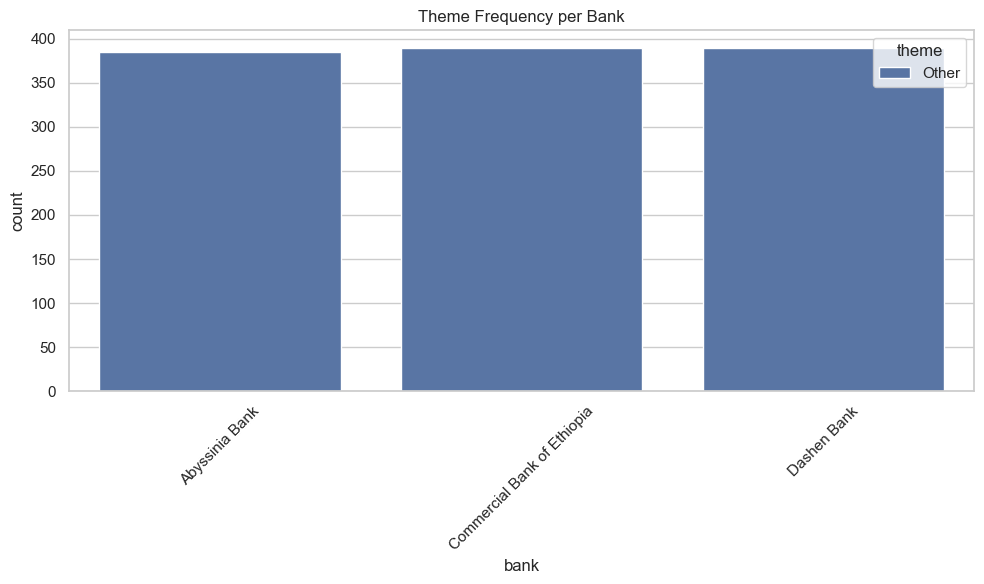

In [ ]:
from collections import Counter

theme_counts = []
for bank in df['bank_name'].unique():
    themes = sum(df[df['bank_name'] == bank]['identified_themes'].tolist(), [])
    counter = Counter(themes)
    for theme, count in counter.items():
        theme_counts.append({
            'bank': bank,
            'theme': theme,
            'count': count
        })

theme_df = pd.DataFrame(theme_counts)

plt.figure(figsize=(10,6))
sns.barplot(data=theme_df, x='bank', y='count', hue='theme')
plt.title("Theme Frequency per Bank")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


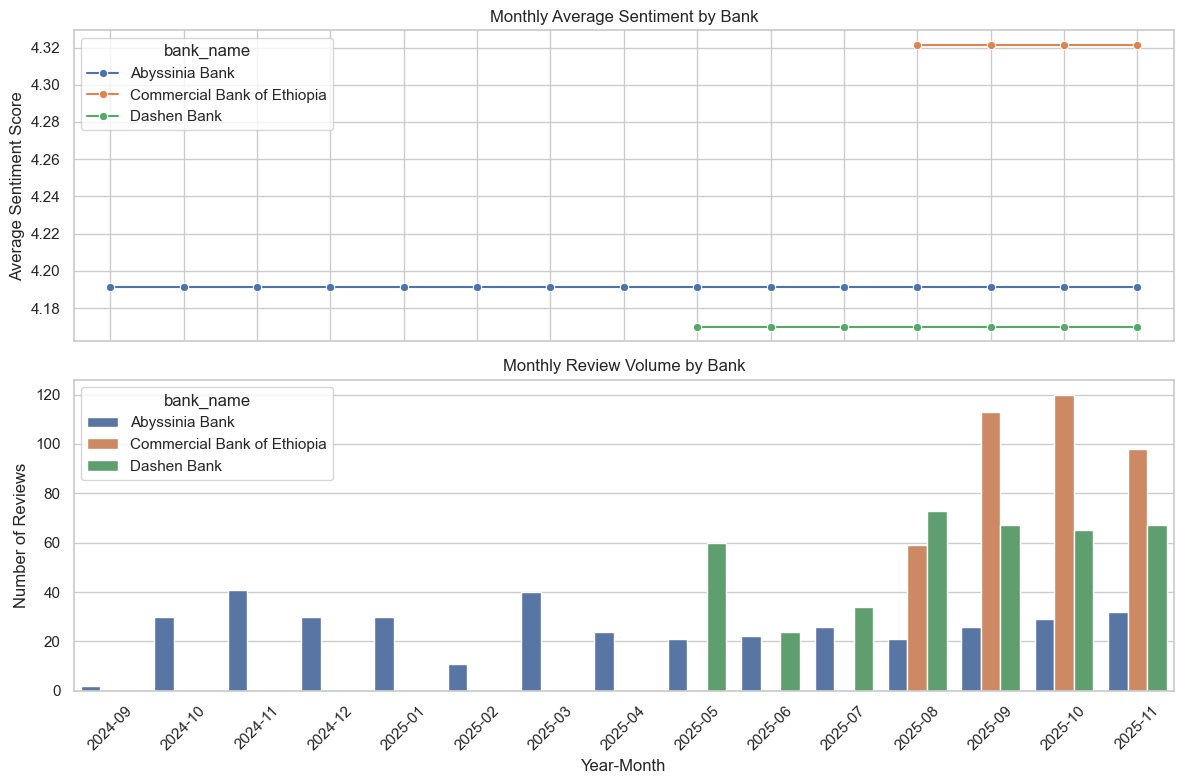

In [ ]:
# Monthly sentiment and review volume trends
monthly = df.groupby(['bank_name', 'review_year', 'review_month']).agg(
    avg_sent=('sentiment_score','mean'),
    reviews=('review_id','count')
).reset_index()

monthly['year_month'] = monthly['review_year'].astype(str) + '-' + monthly['review_month'].astype(str).str.zfill(2)
fig, ax = plt.subplots(2, 1, figsize=(12,8), sharex=True)

sns.lineplot(
    data=monthly,
    x='year_month', y='avg_sent',
    hue='bank_name', marker='o', ax=ax[0]
)
ax[0].set_title('Monthly Average Sentiment by Bank')
ax[0].set_ylabel('Average Sentiment Score')

sns.barplot(
    data=monthly,
    x='year_month', y='reviews',
    hue='bank_name', ax=ax[1]
)
ax[1].set_title('Monthly Review Volume by Bank')
ax[1].set_xlabel('Year-Month')
ax[1].set_ylabel('Number of Reviews')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


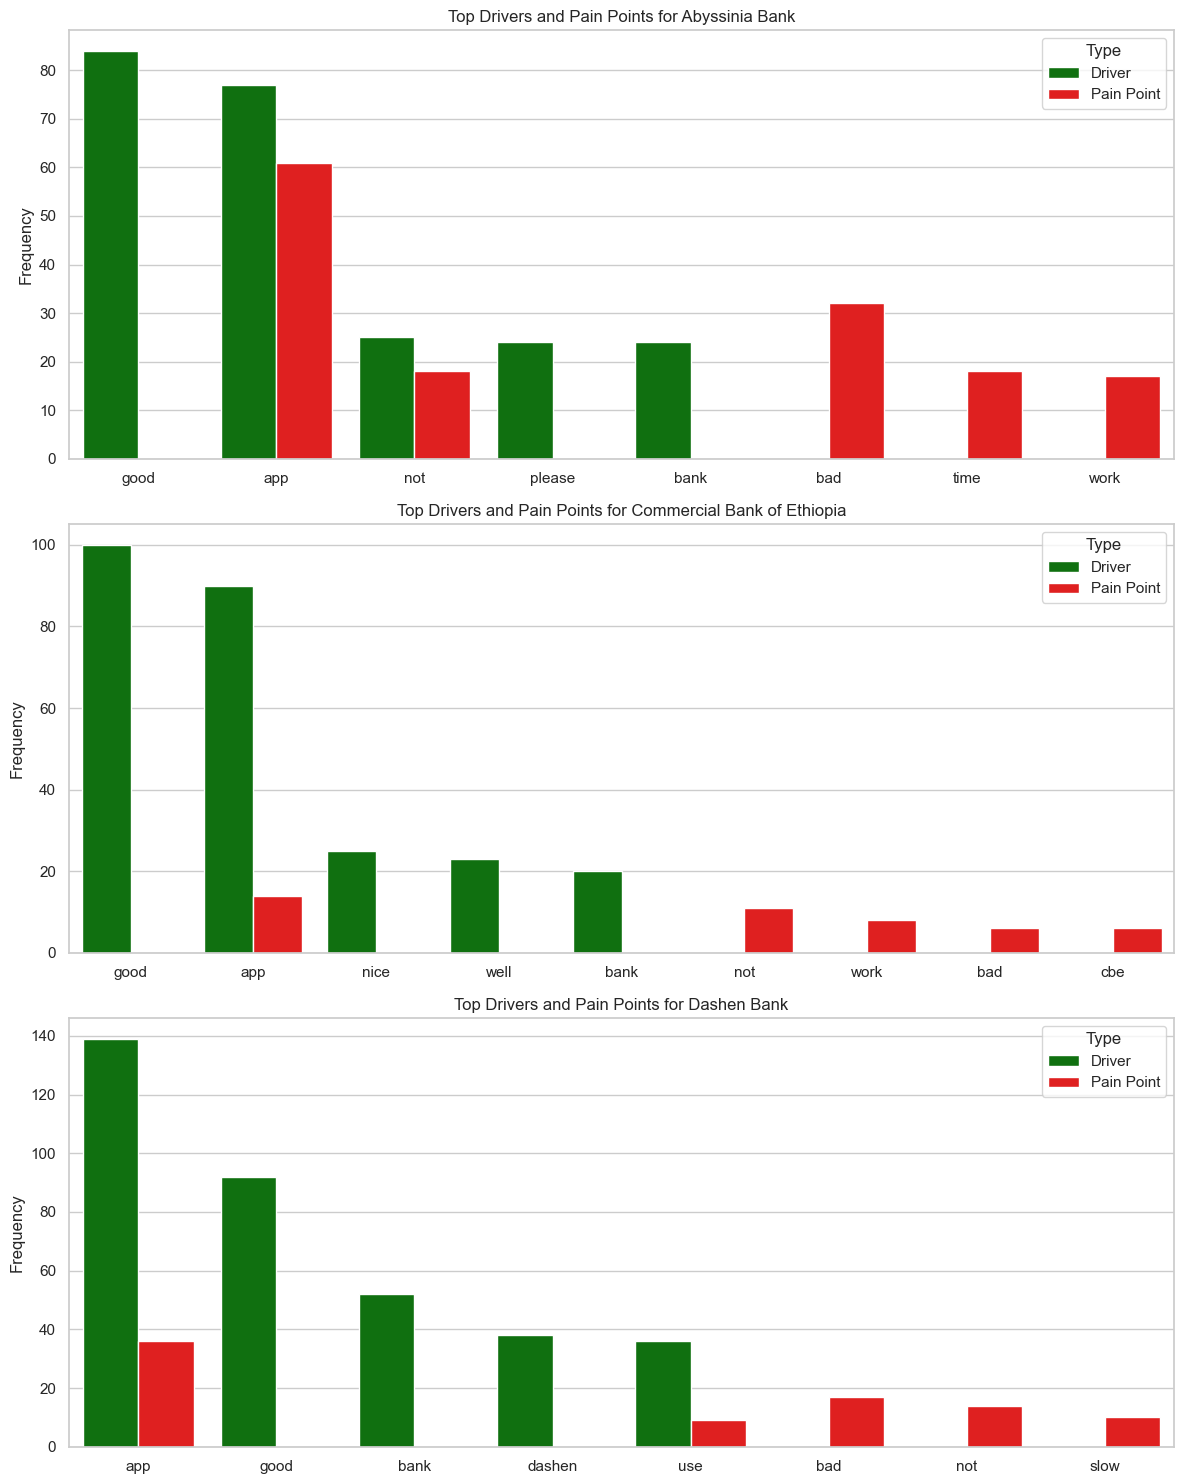

In [44]:
# word frequency plot for drivers and pain points
plot_data = []

for bank in banks:
    insight = insights[bank]
    
    for w, freq in insight['drivers_words'][:5]:
        plot_data.append({'Bank': bank, 'Word': w, 'Type': 'Driver', 'Frequency': freq})
        
    for w, freq in insight['painpoint_words'][:5]:
        plot_data.append({'Bank': bank, 'Word': w, 'Type': 'Pain Point', 'Frequency': freq})

plot_df = pd.DataFrame(plot_data)

sns.set(style="whitegrid")

n_banks = len(banks)
fig, axes = plt.subplots(n_banks, 1, figsize=(12, 5*n_banks), sharex=False)

if n_banks == 1:
    axes = [axes]

for ax, bank in zip(axes, banks):
    bank_df = plot_df[plot_df['Bank'] == bank]
    sns.barplot(
        data=bank_df,
        x='Word',
        y='Frequency',
        hue='Type',
        dodge=True,
        palette={'Driver':'green', 'Pain Point':'red'},
        ax=ax
    )
    ax.set_title(f'Top Drivers and Pain Points for {bank}')
    ax.set_ylabel('Frequency')
    ax.set_xlabel('')
    ax.legend(title='Type')

plt.tight_layout()
plt.show()


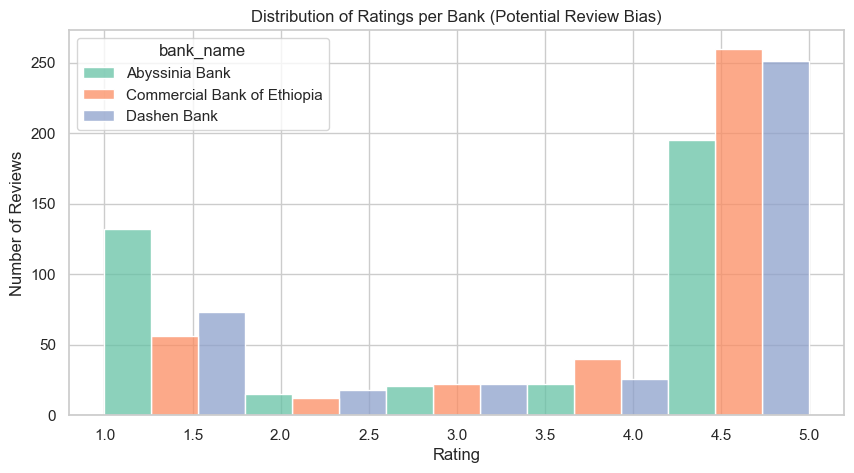

In [ ]:
#  distribution of ratings per bank on potential review bias
sns.set(style="whitegrid")
plt.figure(figsize=(10,5))

sns.histplot(data=df, x='rating', bins=5, hue='bank_name', multiple='dodge', palette='Set2')
plt.title('Distribution of Ratings per Bank (Potential Review Bias)')
plt.xlabel('Rating')
plt.ylabel('Number of Reviews')
plt.show()